In [1]:
import numpy as np
import scipy.stats as st
import pylab as plt
import pandas as pd
import seaborn as sns

In [2]:
# Using the above nested radical formula for g=phi_d 
# or you could just hard-code it. 
# phi(1) = 1.61803398874989484820458683436563 
# phi(2) = 1.32471795724474602596090885447809 
def phi(d, precision=30): 
    x = 2.00
    for i in range(precision): 
        x = pow(1+x,1/(d+1)) 
    return x

In [3]:
def gaussian_icdf(q):
    return st.norm.isf(q)

def identity(x):
    return x

Easy low-discrepancy random numbr generator: http://extremelearning.com.au/unreasonable-effectiveness-of-quasirandom-sequences/

In [4]:
def a_generate(ndim, Npoints, *, seed=0.5, mapper=identity):
    # get the base for the dimension
    g = phi(ndim) 
    # this is the inizialization constant for the array
    alpha = ((1/g)**np.arange(1, ndim+1))%1  
    # reshaping to allow broadcasting
    alpha = alpha.reshape(1, -1) 
    # just the count of the sequence
    base = np.arange(Npoints).reshape(-1, 1) 
    # perform the actual calculation
    z = seed + alpha*base 
    # tale only the decimal part
    z = z % 1
    # return a mapped version to some distribution
    return mapper(z)

In [5]:
a_generate(1,10, mapper=gaussian_icdf)

array([[ 0.        ],
       [ 1.18487221],
       [-0.63126993],
       [ 0.37426935],
       [-1.91315596],
       [-0.22798216],
       [ 0.81266899],
       [-0.93940245],
       [ 0.14014703],
       [ 1.53570072]])

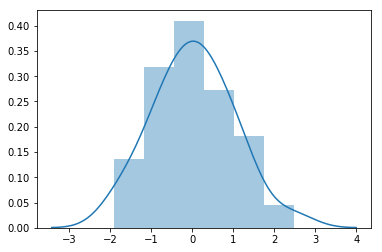

In [8]:
rn = a_generate(1,30, mapper=gaussian_icdf)
sns.distplot(rn)

The convergence using a LDS is way more efficient, acctualy it goes as $O(\frac{1}{N})$

[]

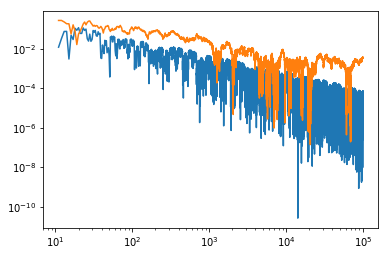

In [10]:
N = 100_000
x_r = a_generate(1, N, mapper=gaussian_icdf)
x_g = plt.randn(N)

n = np.arange(1, len(x_r)+1)
res_r = np.cumsum(x_r)/n
res_g = np.cumsum(x_g)/n

r = 10
plt.plot(n[r:], abs(res_r)[r:])
plt.plot(n[r:], abs(res_g)[r:])
plt.loglog()

We can use the function we prefer as a mapper for the generation

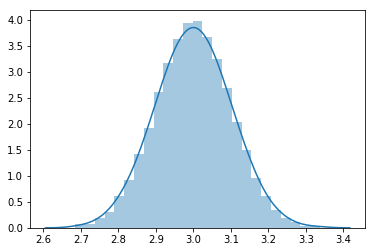

In [11]:
b0 = a_generate(1, 1000, mapper=st.norm(loc=3, scale=0.1).isf)
sns.distplot(b0)

In [12]:
from scipy.integrate import odeint

It's more approriate to use powers of 2 +1 due to the more precision

In [13]:
# derivative
def logistic(state, time, α, β):
    N = state
    δN = α*N - β*N**2
    return δN

# time steps
time = np.linspace(0, 1, 2**7+1)

# starting status
N0 = 0.1

# parameters
α = 10
β = 1

Alway pass arguments as a tuple, even if there is just one.

In [14]:
res = odeint(logistic, y0=N0, t=time, args=(α, β))

It returns by default one colun per variable

In [15]:
res.shape

(129, 1)

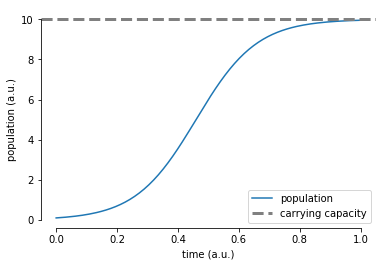

In [19]:
fig, ax = plt.subplots()
ax.plot(time, res, label="population")
ax.set_xlabel("time (a.u.)")
ax.set_ylabel("population (a.u.)")
ax.axhline(α/β, label='carrying capacity', color='gray', linewidth=3, linestyle='--')
ax.legend()
sns.despine(fig, trim=True) #Very useful function

Let's transform that result in a tidy DataFrame

In [20]:
def to_df(result, columns, **other_info):
    res_df = pd.DataFrame(result, columns=columns)
    for key, value in other_info.items():
        res_df[key] = value
    return res_df

In this way we can have a DF for every result

In [21]:
to_df(res, ['population'], α=α, β=β, time=time).head()

,population,α,β,time
0,0.100000,10,1,0.000000
1,0.108038,10,1,0.007812
2,0.116714,10,1,0.015625
3,0.126079,10,1,0.023438
4,0.136184,10,1,0.031250


Now we do a lot of simulation with a lot of values for the alpha parameter

We need to unpack the values in alphas iterating it as a tuple

In [24]:
for a in a_generate(1,3):
    print(a)

[0.5]
[0.11803399]
[0.73606798]


In [25]:
for (a, ) in a_generate(1,3):
    print(a)

0.5
0.1180339887498949
0.7360679774997896


In [23]:
mapper = st.norm(loc=[10], scale=0.5).isf
# 50 values around the average value
alphas = a_generate(1, 50, mapper=mapper)
β = 1

time = np.linspace(0, 1, 2**7+1)

results = []
for idx, (α, ) in enumerate(alphas):
    res = odeint(logistic, y0=N0, t=time, args=(α, β))
    res_df = to_df(res, ['population'], α=α, β=β, time=time, simulation_run=idx)
    results.append(res_df)
results = pd.concat(results)

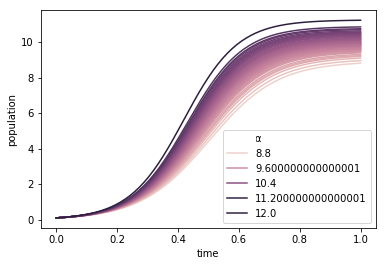

In [26]:
sns.lineplot("time", 'population', data=results, hue='α',
             estimator=None, units='simulation_run')

The identity of these point can be found in the value of `simulation_run`. Otherwise it can not know how to aggregate the points.

## Warning: Beta should be positive!
In these cases we should use a log norml distribution, in order to avoid negative numbers

In [32]:


mapper = st.norm(loc=[1], scale=0.05).isf
# 50 values around the average value
betas = a_generate(1, 50, mapper=mapper)
α =10

time = np.linspace(0, 1, 2**7+1)

results = []
for idx, (β, ) in enumerate(betas):
    res = odeint(logistic, y0=N0, t=time, args=(α,β))
    res_df = to_df(res, ['population'], α=α, β=β, time=time, simulation_run=idx)
    results.append(res_df)
results = pd.concat(results)



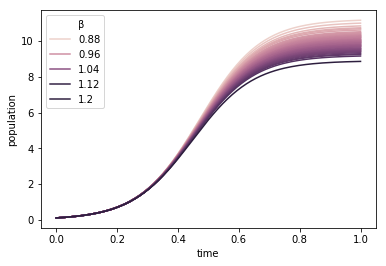

In [33]:
sns.lineplot("time", 'population', data=results, hue='β',
             estimator=None, units='simulation_run')

We can see that  beta only affect the equilibrium point

We might want to study the logistic equation using a different parametrization, maybe a better one.

In [34]:
#Here we changed the meaning of the parameters.
#Beta is very different
def logistic_bis(state, time, α, β):
    N = state
    δN = α*N*(1-N/β)
    return δN

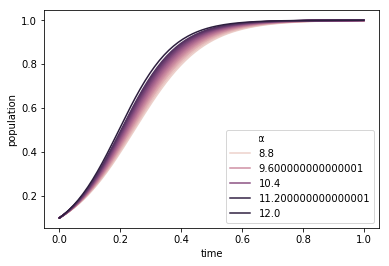

In [36]:
mapper = st.norm(loc=[10], scale=0.5).isf
# 50 values around the average value
alphas = a_generate(1, 50, mapper=mapper)
β = 1

time = np.linspace(0, 1, 2**7+1)

results = []
for idx, (α, ) in enumerate(alphas):
    res = odeint(logistic_bis, y0=N0, t=time, args=(α, β))
    res_df = to_df(res, ['population'], α=α, β=β, time=time, simulation_run=idx)
    results.append(res_df)
results = pd.concat(results)

sns.lineplot("time", 'population', data=results, hue='α',
             estimator=None, units='simulation_run')

In this way alpha affect only the velocity of the problem, it not influence at all the equilibrium position

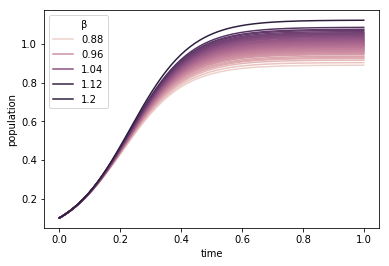

In [38]:
mapper = st.norm(loc=[1], scale=0.05).isf
# 50 values around the average value
betas = a_generate(1, 50, mapper=mapper)
α =10

time = np.linspace(0, 1, 2**7+1)

results = []
for idx, (β, ) in enumerate(betas):
    res = odeint(logistic_bis, y0=N0, t=time, args=(α,β))
    res_df = to_df(res, ['population'], α=α, β=β, time=time, simulation_run=idx)
    results.append(res_df)
results = pd.concat(results)

sns.lineplot("time", 'population', data=results, hue='β',
             estimator=None, units='simulation_run')

Here Beta affect only the equilibrium position

Using different parametrization we can detect different correlations between them.

We always want to use the parameters with the **lowest** correlation between them

In [39]:
def SIR_model(state, time, α, β, γ):
    S, I, R, D = state
    δR = + α*I
    δD = + γ*I
    δI = - γ*I - α*I + β*I*S
    δS = - β*I*S
    return δS, δI, δR, δD 
    
time = np.linspace(0, 5, 2**9+1)
state0 = (1.0, 0.001, 0.0, 0.0)
α, β, γ = 1, 10, 0.3

res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))

In [41]:
S_hat, I_hat, R_hat, D_hat = res.T

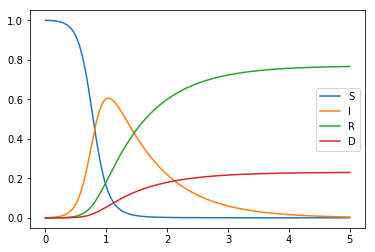

In [42]:
plt.plot(time, S_hat, label='S')
plt.plot(time, I_hat, label='I')
plt.plot(time, R_hat, label='R')
plt.plot(time, D_hat, label='D')

plt.legend()

We can vary the parameters

In [43]:
Nexp = 50
results = []
state0 = (1.0, 0.001, 0.0, 0.0)
α, β, γ = 1.0, 10.0, 0.3
α_seq = a_generate(1, Nexp, mapper=st.norm(loc=[1], scale=0.1).isf)

cols = ['S', 'I', 'R', 'D']
for idx, (α, ) in enumerate(α_seq):
    res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
    res_df = to_df(res, cols, N0=N0, α=α, β=β, γ=γ, time=time, simulation_run=idx, type='varying a')
    results.append(res_df)
results = pd.concat(results, ignore_index=True)

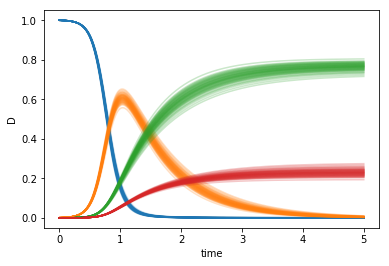

In [44]:
alpha = 0.25
sns.lineplot("time", 'S', data=results, estimator=None, units='simulation_run', alpha=alpha)
sns.lineplot("time", 'I', data=results, estimator=None, units='simulation_run', alpha=alpha)
sns.lineplot("time", 'R', data=results, estimator=None, units='simulation_run', alpha=alpha)
sns.lineplot("time", 'D', data=results, estimator=None, units='simulation_run', alpha=alpha)


In [45]:
Nexp = 50
results = []
state0 = (1.0, 0.001, 0.0, 0.0)

α, β, γ = 1.0, 10.0, 0.3
α_seq = a_generate(1, Nexp, mapper=st.norm(loc=[α], scale=α*0.1).isf)
for idx, (α, ) in enumerate(α_seq):
    res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
    res_df = to_df(res, cols, N0=N0, α=α, β=β, γ=γ, time=time, simulation_run=idx, type='varying α')
    results.append(res_df)

α, β, γ = 1.0, 10.0, 0.3
β_seq = a_generate(1, Nexp, mapper=st.norm(loc=[β], scale=β*0.1).isf)
for idx, (β, ) in enumerate(β_seq):
    res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
    res_df = to_df(res, cols, N0=N0, α=α, β=β, γ=γ, time=time, simulation_run=idx, type='varying β')
    results.append(res_df)

α, β, γ = 1.0, 10.0, 0.3
γ_seq = a_generate(1, Nexp, mapper=st.norm(loc=[γ], scale=γ*0.1).isf)
for idx, (γ, ) in enumerate(γ_seq):
    res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
    res_df = to_df(res, cols, N0=N0, α=α, β=β, γ=γ, time=time, simulation_run=idx, type='varying γ')
    results.append(res_df)
results = pd.concat(results, ignore_index=True)

I see that the parameters represent redundant information, maybe there is a parametrization that better separate the three varyings

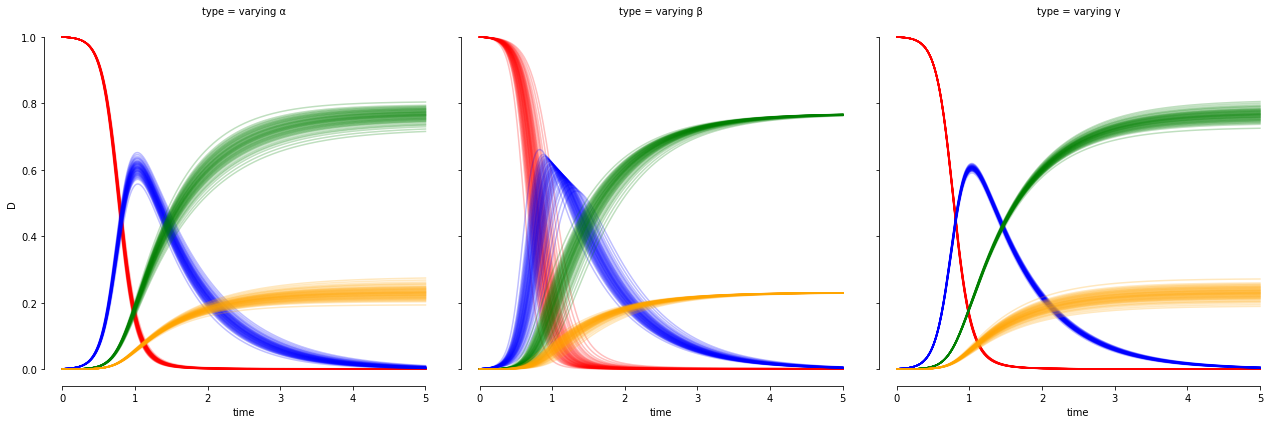

In [46]:
fg = sns.FacetGrid(data=results, col='type', height=6)
fg.map_dataframe(sns.lineplot, "time", 'S', estimator=None, units='simulation_run', alpha=alpha, color='r')
fg.map_dataframe(sns.lineplot, "time", 'I', estimator=None, units='simulation_run', alpha=alpha, color='b')
fg.map_dataframe(sns.lineplot, "time", 'R', estimator=None, units='simulation_run', alpha=alpha, color='g')
fg.map_dataframe(sns.lineplot, "time", 'D', estimator=None, units='simulation_run', alpha=alpha, color='orange')
sns.despine(fg.fig, trim=True)